In [1]:
import sys, os

sys.path.insert(0, '/home/daniil/repos/pytorch-segmentation-detection/vision/')
sys.path.append('/home/daniil/repos/pytorch-segmentation-detection/')

import torch
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.autograd import Variable

from PIL import Image


from pytorch_segmentation_detection.models.detection.resnet_dilated import Resnet18_16s
from pytorch_segmentation_detection.utils.detection import AnchorBoxesManager, display_bboxes_center_xywh

from pytorch_segmentation_detection.transforms import pad_to_size

anchors_per_cell = 9
number_of_classes = 21

number_of_anchors_outputs = anchors_per_cell * 4
number_of_classes_outputs = anchors_per_cell * number_of_classes

output_size = number_of_anchors_outputs + number_of_classes_outputs

model = Resnet18_16s(num_classes=output_size)

model.load_state_dict( torch.load('resnet_18_16s_detection.pth') )
model.cuda().eval()


img_path = '/home/daniil/projects/pascal/dataset/VOCdevkit/VOC2012/JPEGImages/2007_000027.jpg'

#img_path = '/home/daniil/projects/pascal/dataset/VOCdevkit/VOC2012/JPEGImages/2007_000068.jpg'

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
    ])


img_not_preprocessed = Image.open(img_path).convert('RGB')

padded_img = pad_to_size(input_img=img_not_preprocessed, size=(600, 600) )

img = transform(padded_img)

img = img.unsqueeze(0)

img = Variable(img.cuda())

output_tensor = model.forward(img)


/home/daniil/repos/anaconda2/lib/python2.7/site-packages/torch/nn/modules/module.py:482: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  own_state[name].copy_(param)


In [2]:
 # (2, 9*4, 38, 38)
regression_output = output_tensor[:, :number_of_anchors_outputs, :]

# (2, 9*21, 38, 38)
classification_output = output_tensor[:, number_of_anchors_outputs:, :]

# (1, 38, 38, 9*21)
classification_output_aligned = classification_output.permute(0, 2, 3, 1).contiguous()

classification_output_aligned_shape = list(classification_output_aligned.shape)
classification_output_aligned_shape[-1] = anchors_per_cell
classification_output_aligned_shape.append(number_of_classes)

# (1, 38, 38, 9, 21)
classification_output_aligned = classification_output_aligned.view(classification_output_aligned_shape)

_, classification_output_aligned_argmaxed = classification_output_aligned.max(4)

# torch.Size([38, 38, 9])
classification_output_aligned_argmaxed = classification_output_aligned_argmaxed.squeeze()

# (38 * 38 * 9)
classification_output_aligned_argmaxed = classification_output_aligned_argmaxed.view((-1))

# --- Getting anchor boxes


manager = AnchorBoxesManager(input_image_size=(600, 600))

# (38*38*9, 4) - aligned with the classification output
anchor_boxes = manager.anchor_boxes.view((-1, 4))

In [3]:
import numpy as np

np.unique(classification_output_aligned_argmaxed.cpu().data.numpy())

array([ 0, 15])

In [5]:
activated_anchor_boxes = anchor_boxes[torch.nonzero(classification_output_aligned_argmaxed.cpu().data == 15), :].squeeze()

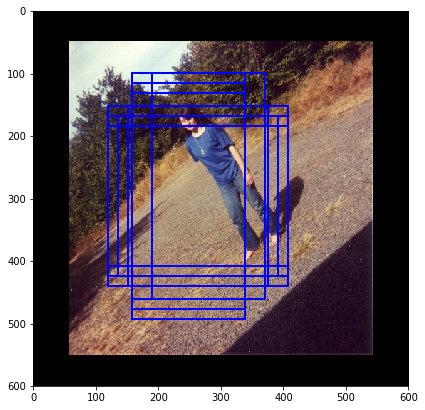

In [6]:
display_bboxes_center_xywh(bboxes_center_xywh=activated_anchor_boxes, img=padded_img)